# Mesmer example with Polaris image

This sample code runs Mesmer locally for a Polaris generated component tif, 
to create cell segmentation masks and export some cell metrics for downstream analysis. 

This was run in a conda environment, deepcell, with deepcell installed via `pip install deepcell`
This installs dependencies including deepcell-tf (tensorflow), but I used conda to install numpy, pandas, scikit-image, matplotlib, seaborn, and xarray. 

`model = Mesmer` will cause a download of the Mesmer model

**Useful links**  
https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html#mesmer

https://github.com/vanvalenlab/intro-to-deepcell

Sample code for Vanvalen/Angelo lab publication:  
https://github.com/vanvalenlab/publication-figures/tree/master/2021-Greenwald_Miller_et_al-Mesmer


In [31]:
import numpy as np
import os
import tifffile as tif
import fnmatch
import re

from skimage import io, color, filters, exposure
import cv2

import matplotlib.pyplot as plt
# %matplotlib inline 

# pip install deepcell
from deepcell.applications import Mesmer
from deepcell_toolbox.utils import tile_image, untile_image



In [32]:
# Set file paths
root_dir = '/Users/annmstrange/Documents/Projects/Tumor IF'
component_img_path='Panel2/020522 P28BatchAnalysis3x/components' # location for *_component_data.tif

In [33]:
def get_files_in_folder (src, pattern):
    '''
    Args: src is the full path where to look eg './Projects/Tumor IF/Panel2/013022 P28Images_full'
    pattern: string like '*_pattern.tif' to use with fnmatch.filter
    Returns: list of full filenames
    '''
    # build list of filenames we want
    fname_list = []

    for dirpath, dir, files in os.walk(src):
        for filename in fnmatch.filter(files, pattern):
            fname = filename
            fullname = os.path.join(dirpath, filename)
            fname_list.append(fullname)
            
    return fname_list   

In [34]:
# get a component from our data
fname_component_3x = get_files_in_folder(
    os.path.join(root_dir, component_img_path), '*_component_data.tif') 
component_file1 = fname_component_3x[0]
component_file1

'/Users/annmstrange/Documents/Projects/Tumor IF/Panel2/020522 P28BatchAnalysis3x/components/091221 P9HuP28 #14 S15-014984 A4_[17537,46960]_component_data.tif'

In [35]:
# Todo: Ask TIFF file what markers we have instead of manually listing here

# list of labels for channels Panel2
channels = ['CD3','pSTAT3 Y705', 'CD4', 'pSTAT5','pSTAT3 S727','pSTAT1', 'SOX10S100',
            'CD8','DAPI','Autofluorescence']


In [36]:
# load the first file
img_component = io.imread(fname_component_3x[0], plugin="tifffile")
img_component.shape
#(10, 465, 620). for 40X Polaris component_data.tif file

(10, 465, 620)

In [37]:
# display each channel image

def plot_img(ax, img, title=None):
    '''
    Shows greyscale channels of multiimage tiff, single channel of an image expected
    '''
    #print(img.shape)
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

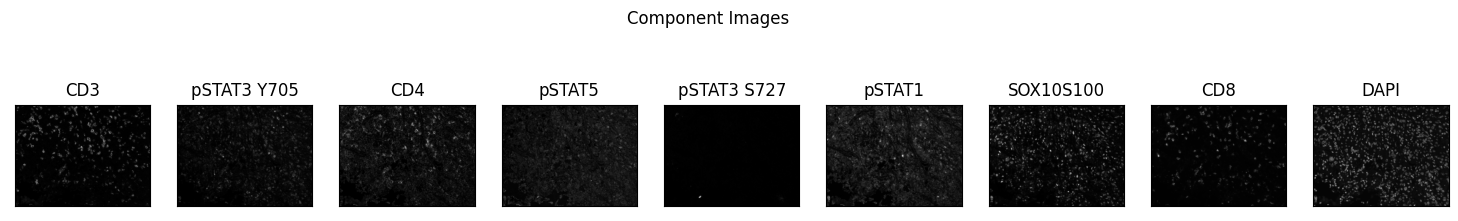

In [38]:
def plot_imgs(img, channels, title=None):
    '''
    Given a multilayer image (np.array), return figure of channel images
    ''' 
    fig, axs = plt.subplots(1, 9)
    fig.set_size_inches(18.5, 3)
    for i in np.arange(0,9):
        plot_img(axs[i], img[i,:,:], channels[i]  )
    fig.suptitle(title)    
    
    return fig    

#test the function
figi = plot_imgs(img_component, channels, "Component Images")
plt.show(figi)



In [39]:
# DAPI only (position 8 will always be DAPI from Polaris)
dapi_img = img_component[8, :, :]
dapi_img.shape



(465, 620)

In [40]:
# tile to squares:  what's greatest common denom of my file's dimension

np.gcd(dapi_img.shape[0], dapi_img.shape[1])  # 155 
x_tiles = dapi_img.shape[1] / 155
y_tiles = dapi_img.shape[0] / 155

print('tiles needed: {} x {} is {}'.format(x_tiles, y_tiles, x_tiles * y_tiles))


tiles needed: 4.0 x 3.0 is 12.0


(155, 155)


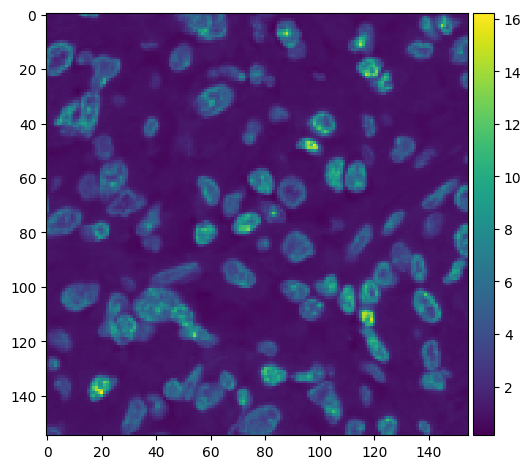

In [41]:
tile1 = dapi_img[:155,:155]
print(tile1.shape)
io.imshow(tile1)

In [42]:
# Load the images.  With only a good nuclear marker, here I used the same one for both.
# Another option would be to combine some other cytoplasm markers into their own channel

im1 = tile1
im2 = tile1

# Combined together and expand to 4D
im = np.stack((im1, im2), axis=-1)
im = np.expand_dims(im,0)

# Create the application
model = Mesmer()



In [43]:
# create the labeled image using the Mesmer model
labeled_image = model.predict(im)


In [44]:
type(model)

deepcell.applications.mesmer.Mesmer

In [45]:
labeled_image.shape

(1, 155, 155, 1)

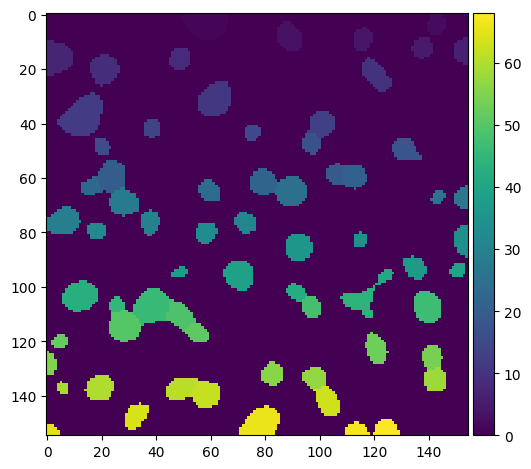

In [46]:
io.imshow(labeled_image[0,:,:,0])

## Tile/untile for non-square images

In [47]:
# How to tile/untile

#def tile_image(image, model_input_shape=(512, 512),
#               stride_ratio=0.75, pad_mode='constant'):
    """
    Tile large image into many overlapping tiles of size "model_input_shape".

    Args:
        image (numpy.array): The image to tile, must be rank 4.
        model_input_shape (tuple): The input size of the model.
        stride_ratio (float): The stride expressed as a fraction of the tile size.
        pad_mode (str): Padding mode passed to ``np.pad``.

    Returns:
        tuple: (numpy.array, dict): A tuple consisting of an array of tiled
            images and a dictionary of tiling details (for use in un-tiling).

IndentationError: unexpected indent (42615908.py, line 5)

In [ ]:
img_class_4 = dapi_img.reshape(1,dapi_img.shape[0],dapi_img.shape[1],1)


tiled_data, tile_info = tile_image(img_class_4, model_input_shape=(256, 256), stride_ratio=1)


In [ ]:
print(tiled_data.shape)
print(tile_info)

In [ ]:
io.imshow(tiled_data[0,:,:,0])

In [ ]:
io.imshow(tiled_data[1,:,:,0])

In [ ]:
# The 

print(tiled_data.shape)
print(im.shape)

# Combined together and expand to 4D (how to just use DAPI?)
im = np.stack((tiled_data, tiled_data), axis=3)[:,:,:,:,0]
print(im.shape)
#im = np.expand_dims(im,0)

model_output = model.predict(im )
#inner_distance, pixelwise = model._untile_output(model_output, tile_info)

In [ ]:
model_output.shape

In [ ]:
result = model._untile_output(model_output, tile_info)

In [ ]:
result.shape


In [ ]:
# retiled:
io.imshow(result[0,:,:,0])

In [ ]:
io.imshow(dapi_img)

## Unaddressed issues


As a proof of concept, some important steps have not been addressed including:  
* cells along the tile edges appear cut off
* ensuring cell ID uniqueness (this is addressed in code for Figure 5 in publication code, search morph_id)
* proper use of a cytoplasm marker
* haven't tested that the right number of cells were found 
